# Instructions

1. Install all the requirements with pip
2. Setup Cloudinary
3. Check the 'Put your keys here' section below
4. Create a field that will be used to store compressed images
5. Setup the 'Config' section below

Notes:

* Tested on python 3. You'll need a few extensions
* Cloudinary is used as a free cloud resampling and storage service (files must be at a URL for Airtable to use them)
* Looks at the field 'Name' for debugging
* Compresses from field source_field into field 'Photo (compressed)'
* Uses same filenames in general (cloudinary default behaviour)
* Starts with some reports about how to 

Requirements:

* pyairtable
* seahorn
* matplotlib
* cloudinary
* pillow

In [2]:
from pyairtable import Table, utils
import urllib3
from pathlib import Path
from io import BytesIO
from PIL import Image
import seaborn
import math
import matplotlib.pyplot as plt
import requests
import cloudinary
import cloudinary.uploader

http = urllib3.PoolManager()

# Put your keys here:

In [3]:
airtable_token = ""
base_id = ""

cloudinary.config(
    cloud_name = "",
    api_key = "",
    api_secret = "",
    secure = "true"
)

# Config

In [14]:
table_name = 'Things'
source_field = 'Photo'
target_field = 'Photo (Compressed)'

# this is used for printing the name in debug
name_field = 'Name'

# should we not perform the conversion if the target_field already has content
ignore_when_output_populated = True

# default to 2MB
max_photo_size = 2 * 1000 * 1000

# default to 4096px
max_photo_resolution = 4096


In [5]:
table = Table(airtable_token, base_id, table_name)

# Histogram of file sizes

## Get file size data

In [6]:
file_sizes = []

for records in table.iterate():
    for row in records:
        if source_field in row['fields']:
            for photo in row['fields'][source_field]:
                file_sizes.append(photo['size'])

## Plot histogram

<AxesSubplot:ylabel='Count'>

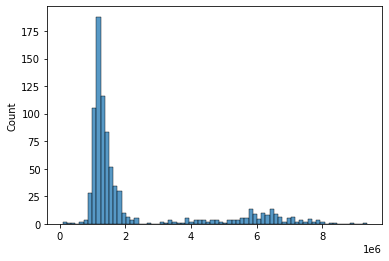

In [7]:
seaborn.histplot(data=file_sizes)

## Plot pie chart by file size

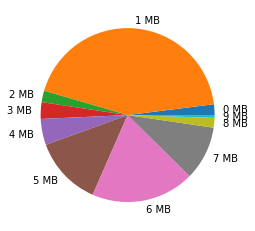

In [8]:
plot_file_sizes = {}

for file_size in file_sizes:
    file_size_mb = math.floor(file_size / 1000000)
    key = "{0} MB".format(file_size_mb)
    if key in plot_file_sizes:
        plot_file_sizes[key] = plot_file_sizes[key] + file_size
    else:
        plot_file_sizes[key] = file_size

plot_file_size_keys_sorted = sorted(plot_file_sizes.keys())
plot_file_size_values = [plot_file_sizes[x] for x in plot_file_size_keys_sorted]

# plot_colors = seaborn.color_palette('pastel')[0:len(plot_file_sizes)]
plt.pie(plot_file_size_values, labels = plot_file_size_keys_sorted)
plt.show()


# Function to reduce a single image size

## Offline version

This is not used

In [9]:
def reorient_img(pil_img):
    img_exif = pil_img.getexif()

    if len(img_exif):
        if img_exif[274] == 3:
            pil_img = pil_img.transpose(Image.ROTATE_180)
        elif img_exif[274] == 6:
            pil_img = pil_img.transpose(Image.ROTATE_270)
        elif img_exif[274] == 8:
            pil_img = pil_img.transpose(Image.ROTATE_90)
            
    return pil_img

In [10]:
def reduce_image_url_locally(original_url):
    # load image from url
    print('loading, ', end = "")
    request_original_image = http.request('GET', original_url)
    if request_original_image.status != 200:
        raise "Couldn't load original image"

    original_data = BytesIO(request_original_image.data)
    image = Image.open(original_data)
    
    # rotate image if needed
    image = reorient_img(image)

    # resample resolution if required
    if photo['width'] > max_photo_resolution or photo['height'] > max_photo_resolution:
        print('resampling, ', end = "")
        image.thumbnail((max_photo_resolution, max_photo_resolution), Image.ANTIALIAS)

    # save until file size is small
    original_filename = Path(photo['filename'])
    temp_filepath = str(original_filename.with_suffix('')) + " (compressed).jpg"
    small_enough = False
    quality = 100
    while not small_enough:
        print('saving, ', end = "")
        quality = quality - 5
        image.save(temp_filepath, quality=quality)
        new_file_size = os.path.getsize(temp_filepath)
        if new_file_size < photo['size'] and new_file_size < max_photo_size:
            small_enough = True

    # upload to temporary storage
    
    with open(temp_filepath, 'rb') as file:
        print('uploading, ', end = "")
        upload_request = requests.post('https://tmp.ninja/upload.php', files={'files[]': file})
        if upload_request.status_code != 200:
            raise "Failed to upload converted image"

        if not upload_request.json()['success']:
            raise "Failed to upload converted image"
    
    print(temp_filepath)
    
    return upload_request.json()['files'][0]['url'], temp_filepath

## Single image transform using Cloudinary

In [11]:
def reduce_image_size_cloudinary(photo):
    transformation = None

    if photo['width'] > max_photo_resolution or photo['height'] > max_photo_resolution:
        transformation = {
            'width' : max_photo_resolution,
            'height' : max_photo_resolution,
            'crop' : 'limit'
        }

    is_ok_size = False

    quality = 80
    # progressively reduce quality until we hit target
    while not is_ok_size:
        print('uploading, ', end = "")
        cloudinary_image = cloudinary.uploader.upload_image(original_url)
        compressed_url = cloudinary_image.build_url(quality=quality, transformation=transformation)
        print('downloading, ', end = "")
        response = requests.get(compressed_url)
        if response.status_code != 200:
            raise "HTTP error on getting compressed image"
        new_size = len(response.content)
        is_ok_size = new_size <= max_photo_size

        quality -= 5

    print(photo['filename'])
    print("{0} MB -> {1} MB".format(round(photo['size'] / 1000000, 2), round(new_size / 1000000, 2)))
    
    return compressed_url

## Perform on all images

In [ ]:
done = False
images_per_row = {}

index = 0
for records in table.iterate():
    for row in records:
        index = index + 1

        if source_field in row['fields']:
            new_attachments = []
            any_conversions = False

            print(index)

            if target_field in row['fields'] and ignore_when_output_populated:
                continue
            
            for photo in row['fields'][source_field]:
                original_url = photo['url']
                if photo['size'] > max_photo_size:
                    any_conversions = True        
                    try:
                        converted_url = reduce_image_size_cloudinary(photo)
                        new_attachments.append(utils.attachment(converted_url, filename=photo['filename']))
                    except BaseException as error:
                        print("Failed : ", error)
                        new_attachments.append(utils.attachment(original_url, filename=photo['filename']))
                else:
                    new_attachments.append(utils.attachment(original_url, filename=photo['filename']))
            
            # seems they get listed in reverse order
            new_attachments.reverse()
            
            if any_conversions and name_field in row['fields']:
                print(row['fields'][name_field])
            
            if len(new_attachments) > 0:
                id = row['id']
                images_per_row[id] = new_attachments
                update_result = table.update(id, { target_field : new_attachments})

Prior total file size :  1850900547
New total file size :  1083553219


[Text(0.5, 1.0, 'New file sizes [MB]')]

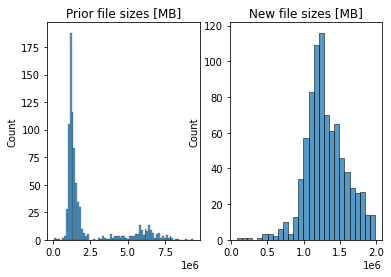

In [22]:
new_file_sizes = []

for records in table.iterate():
    for row in records:
        if source_field in row['fields']:
            for photo in row['fields'][target_field]:
                new_file_sizes.append(photo['size'])
                
print("Prior total file size : ", sum(file_sizes))
print("New total file size : ", sum(new_file_sizes))

fig, axes = plt.subplots(1, 2)
seaborn.histplot(data=file_sizes, ax=axes[0]).set(title="Prior file sizes [MB]")
seaborn.histplot(data=new_file_sizes, ax=axes[1]).set(title="New file sizes [MB]")